In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
pd.set_option("display.max_columns", None)
from scipy.stats import f_oneway
import xgboost as xgb
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

##os.chdir('/content/drive/MyDrive/Depression_Classification')

In [ ]:
from huggingface_hub import login
from google.colab import userdata

my_secret_key = userdata.get('HF_TOKEN')
# Log in programmatically
login(token=my_secret_key)

In [ ]:
import re

def extract_text(input_string):
  # Check if the input is a string
    if not isinstance(input_string, str):
        print(input_string)
        raise ValueError("Expected a string input")
    # Use regex to find all text within parentheses and remove the text itself
    matches = re.findall(r'\((.*?)\)', input_string)

    if not matches:
        return input_string

    # Join the extracted texts with a space and return them
    return ' '.join(matches)

# Below helper function creates question-answer pairs (without filtering)
def create_question_answer_pairs(interview):
    question_answer_pairs = []
    current_question = []
    current_response = []

    for index, row in interview.iterrows():
        row['value'] = extract_text(str(row['value']))
        if row['speaker'] == "Ellie":
            # If there's an existing question and response, store the pair
            if current_question and current_response:

                question_answer_pairs.append({
                    'question': " ".join(current_question),
                    'answer': ". ".join(current_response)
                })
                current_response = []  # Reset responses for the next question
                current_question = []  # Reset question for the next batch

            # Add the new question or follow-up from Ellie to the current question
            current_question.append(str(row['value']))

        elif row['speaker'] == "Participant" and current_question:
            current_response.append(str(row['value']))

    # Add the last question-answer pair if it exists
    if current_question and current_response:

        question_answer_pairs.append({
            'question': " ".join(current_question),
            'answer': ". ".join(current_response)
        })

    return pd.DataFrame(question_answer_pairs, columns=['question', 'answer'])

In [ ]:
# Function to create chunks of QA pairs with overlaps
def chunk_qa_pairs(df, max_tokens=80, max_overlap_tokens=40):
    chunks = []
    current_chunk = []
    current_chunk_word_count = 0

    # Combine questions and answers
    qa_pairs = [f"Interviewer: {row['question']} Interviewee: {row['answer']}" for _, row in df.iterrows()]

    for pair in qa_pairs:
        # Count words in the current pair
        pair_word_count = len(pair.split())

        # Check if adding this pair exceeds the max tokens
        if current_chunk_word_count + pair_word_count > max_tokens:
            # Save the current chunk
            chunks.append(" ".join(current_chunk))

            # Prepare for the next chunk
            # Determine overlap (complete QA pairs)
            overlap = []
            overlap_word_count = 0

            # Start from the last added complete pairs until it hits the token limit
            for qa in reversed(current_chunk):
                overlap_word_count += len(qa.split())
                if overlap_word_count >= max_overlap_tokens:
                    break
                overlap.append(qa)

            # Reverse to maintain original order
            overlap.reverse()

            # Start new chunk with overlap
            current_chunk = overlap
            current_chunk_word_count = sum(len(q.split()) for q in current_chunk)

        # Add the current pair to the chunk
        current_chunk.append(pair)
        current_chunk_word_count += pair_word_count

    # Add the last chunk if it has content
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Create dictionary of {participant_id : PHQ_Binary}
id_depression_label_map = {}
all_ids = set()
sheet_name = 'Metadata_mapping'
## Change File location 1
file_path = 'DAIC demographc data.xlsx'
data_csv = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(len(data_csv['Participant_ID'])):
    id_depression_label_map[data_csv['Participant_ID'][i]] = data_csv['PHQ_Binary'][i]
    all_ids.add(data_csv['Participant_ID'][i])


In [ ]:
sheet_name = 'Interview_Data'
## Change File location 2
file_path = '/content/drive/MyDrive/Depression_Classification/DAIC demographc data.xlsx'
race_csv = pd.read_excel(file_path, sheet_name=sheet_name)
first_name = list(race_csv.iloc[0].values)
race_csv.drop(index=0, inplace=True)
race_csv.columns = ['Participant_ID', 'Condition', 'Age', 'Gender', 'Education', 'Race']

id_race_map = {}
for i in range(len(race_csv['Participant_ID'])):
  id_race_map[list(race_csv['Participant_ID'])[i]] = list(race_csv['Race'])[i] - 1

sheet_name = 'Metadata_mapping'
#file_path = '/content/drive/MyDrive/Depression_Classification/DAIC demographc data.xlsx'
race_csv = pd.read_excel(file_path, sheet_name=sheet_name)
first_name = list(race_csv.iloc[0].values)
race_csv.drop(index=0, inplace=True)


id_gender_map = {}
for i in range(len(race_csv['Participant_ID'])):
  id_gender_map[list(race_csv['Participant_ID'])[i]] = [0 if list(race_csv['Gender'])[i] == 'male' else 1][0]

race = {
    0: 'African American',
    1: 'Asian',
    2: 'White/Caucasian',
    3: 'Hispanic',
    4: 'Native American',
    5: 'Native Hawaiian/Other Pacific Islander',
    6: 'Other'
}
gender = {
    0: 'Male',
    1: 'Female'
}


id_depression_label_map = {}
all_ids = set()
sheet_name = 'Metadata_mapping'
#file_path = '/content/drive/MyDrive/Depression_Classification/DAIC demographc data.xlsx'
extended_data_csv = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(len(extended_data_csv['Participant_ID'])):
    id_depression_label_map[extended_data_csv['Participant_ID'][i]] = extended_data_csv['PHQ_Binary'][i] #[extended_data_csv['PHQ_Binary'][i], extended_data_csv['PHQ_Score'][i]]
    all_ids.add(extended_data_csv['Participant_ID'][i])

## Change File location 3
labels_csv = pd.read_csv('/content/drive/MyDrive/Depression_Classification/train_split_Depression_AVEC2017.csv')
for i in range(len(labels_csv['Participant_ID'])):
  id_depression_label_map[labels_csv['Participant_ID'][i]] = extended_data_csv['PHQ_Binary'][i]
  all_ids.add(labels_csv['Participant_ID'][i])


# List of specific Participant_IDs you want to filter
participant_ids = list(all_ids)  # Replace with your specific Participant_IDs

id_gender_map[302] = 0

to_ignore = []
## Change File location 4
labels_csv = pd.read_csv('/content/drive/MyDrive/Depression_Classification/test_split_Depression_AVEC2017.csv')
for i in range(len(labels_csv['participant_ID'])):
  to_ignore.append(labels_csv['participant_ID'][i])

id_gender_map[0] = []
id_gender_map[1] = []
for i in id_gender_map:
  if id_gender_map[i] == 0:
    id_gender_map[0].append(str(i))
  if id_gender_map[i] == 1:
    id_gender_map[1].append(str(i))
male_participant_ids = id_gender_map[0]
female_participant_ids = id_gender_map[1]

participant_ids = male_participant_ids

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
import torch

max_len = 510
ids_collected = []
all_qas_df = []
def collect_train_test_data(directory):
    X_train = []
    Y_train = []
    attention_masks = []
    for filename in os.listdir(directory):
      if filename.endswith(".csv"):
            interview_id = re.findall(r'\d+', filename)[0]
          # change here for male and female analysis
          #if interview_id in female_participant_ids:
            ids_collected.append(interview_id)

            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path, delimiter='\t')
            df.drop(columns=['start_time', 'stop_time'], axis=1, inplace=True)
            df.fillna('', inplace=True)

            # Step 1: Create QA Pair
            qa_df = create_question_answer_pairs(df)
            all_qas_df.append(qa_df)
            Y_train.append(id_depression_label_map[int(interview_id)])

    return all_qas_df, Y_train

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

# Load the data
## Change Folder location 1
directory = '/content/drive/MyDrive/Depression_Classification/transcripts_csv'
all_qas_df, Y_train = collect_train_test_data(directory)


In [ ]:
print(len(all_qas_df))

189


# Generate QA sentences

In [ ]:
# Sample list of dataframes named dfs, each with columns 'Question' and 'Answer'
# Replace `dfs` with the name of your actual list of dataframes

def concatenate_conversations(dfs):
    all_conversations = []

    for df in dfs:
        conversation = ""

        for _, row in df.iterrows():
            # Adding prefix for interviewer question
            conversation += f"[Interviewer]: {row['question']} "

            # Adding prefix for patient answer
            conversation += f"[Patient]: {row['answer']} "

        # Strip any trailing whitespace and add to the list of conversations
        all_conversations.append(conversation.strip())

    return all_conversations

# Example usage
concatenated_conversations = concatenate_conversations(all_qas_df)

#with open("conversations.pkl", "rb") as file:
#    loaded_conversations = pickle.load(file)


NameError: name 'pickle' is not defined

In [ ]:
import pickle
## Change File location 5
with open('/content/adjective_embeddings.pkl', 'rb') as file:
    true_dict = pickle.load(file)

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load transformer model and tokenizer
model_name = "mental/mental-bert-base-uncased"  # or any transformer model of choice
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Function to find adjectives in a sentence using spaCy
def extract_adjectives_spacy(sentence):
    doc = nlp(sentence)
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    return adjectives

# Function to get a window of context around the current QA pair
def build_context_window(df, current_index, window_before=1, window_after=1):
    context = []
    # Add previous QA pairs within the window
    start_index = max(0, current_index - window_before)
    # Add next QA pairs within the window
    end_index = min(len(df), current_index + window_after + 1)

    for i in range(start_index, end_index):
        context.append(df.iloc[i]['question'] + " " + df.iloc[i]['answer'])

    return " ".join(context)

# Function to get embeddings for adjectives in context
def get_adjective_embeddings(df_list, Y_train, parameters, window_before=1, window_after=1):
  Acc = []
  Bacc = []
  Prec = []
  Rec = []
  F1 = []
  for parameter in range(len(parameters)):
      embeddings = []
      y_prediction = []
      c = 0
      for df in df_list:
          adj_count = 0
          adj_depressed = 0
          for i, row in df.iterrows():
              interviewer_text = row['question']
              interviewee_text = row['answer']

              # Extract adjectives from interviewee's response
              adjectives = extract_adjectives_spacy(interviewee_text)
              if not adjectives:
                  continue

              # Build context window around the current QA pair
              context = build_context_window(df, i, window_before=window_before, window_after=window_after)

              # Truncate or pad context to fit within 512 tokens
              inputs = tokenizer(context, return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)

              # Get embeddings from the model
              with torch.no_grad():
                  outputs = model(**inputs)

              # Get embeddings for adjectives
              for adj in adjectives:

                  # Find the index of each adjective in the tokenized context
                  adj_tokens = tokenizer.tokenize(adj)
                  adj_token_id = tokenizer.convert_tokens_to_ids(adj_tokens[0])  # ID of the first token of the adjective
                  adj_index = (inputs.input_ids[0] == adj_token_id).nonzero(as_tuple=True)[0]  # Find position of token in input

                  if len(adj_index) > 0:  # Ensure adjective token was found
                      adj_embedding = outputs.last_hidden_state[0, adj_index[0], :].cpu().numpy()
                      #embeddings.append((adj, adj_embedding))
                      if adj in true_dict:
                          adj_count+=1
                          true_embedding = true_dict[adj]
                          similarity = cosine_similarity([adj_embedding], [true_embedding])[0][0]
                          #print(f"Cosine similarity for '{adj}': {similarity}")
                          if similarity>parameters[parameter][0]:
                            adj_depressed+=1

          try:
            if (adj_depressed/adj_count) > parameters[parameter][0]:
              y_prediction.append(1)
            else:
              y_prediction.append(0)
          except Exception as exp:
              y_prediction.append(0)
          c+=1
      predicted_labels = y_prediction
      true_labels = Y_train
      # Calculating metrics
      precision = precision_score(true_labels, predicted_labels, average='binary')
      recall = recall_score(true_labels, predicted_labels, average='binary')
      f1 = f1_score(true_labels, predicted_labels, average='binary')
      balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
      accuracy = accuracy_score(true_labels, predicted_labels)

      # Printing results
      #print(f"Precision: {precision}")
      #print(f"Recall: {recall}")
      #print(f"F1 Score: {f1}")
      #print(f"Balanced Accuracy: {balanced_accuracy}")
      #print(f"Accuracy: {accuracy}")

      Acc.append(accuracy)
      Bacc.append(balanced_accuracy)
      Prec.append(precision)
      Rec.append(recall)
      F1.append(f1)
      print(parameter)
  return Acc, Bacc, Prec, Rec, F1

# Example usage
# df_list is a list of dataframes, each with 'Interviewer' and 'Interviewee' columns
# Example: df_list = [df1, df2, ...]
parameters = [(0.75,0.15), (0.7,0.15)]#[(0.7, 0.2) - 525, (0.7,0.3) - 525, (0.65,0.15) - 511, (0.65,0.25) - 511, (0.6,0.3) - 511]#[(0.7, 0.25) - 5.25]#[(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
Acc, Bacc, Prec, Rec, F1 = get_adjective_embeddings(all_qas_df, Y_train, parameters, window_before=15, window_after=15)


Using device: cuda


Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1


#Plot the graph

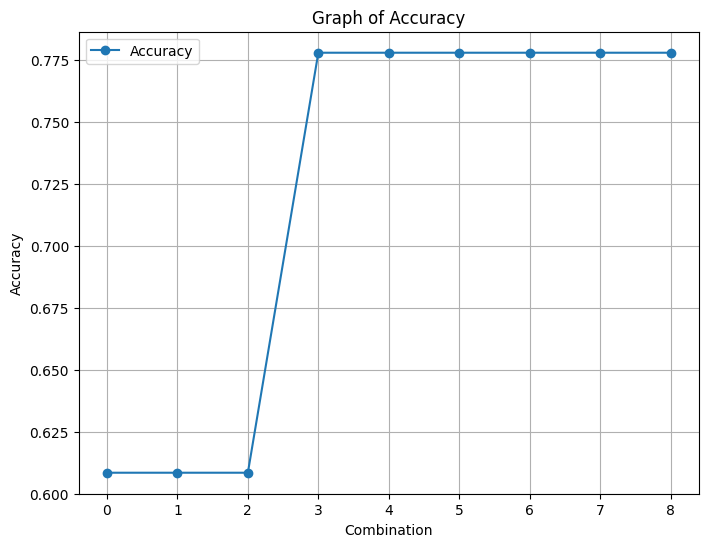

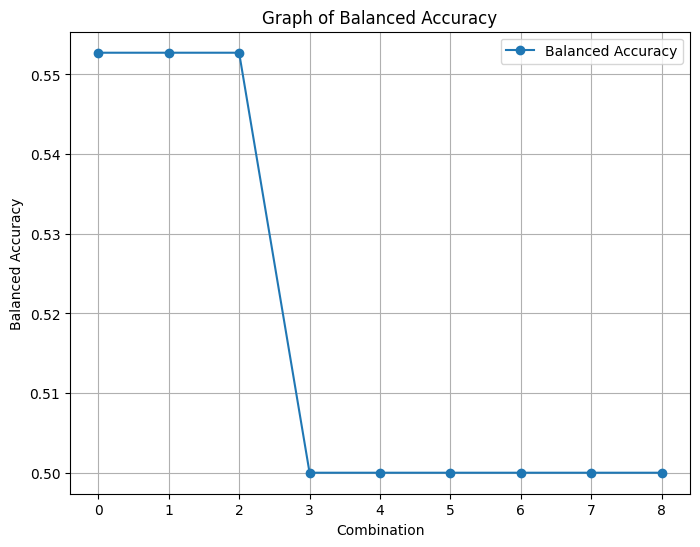

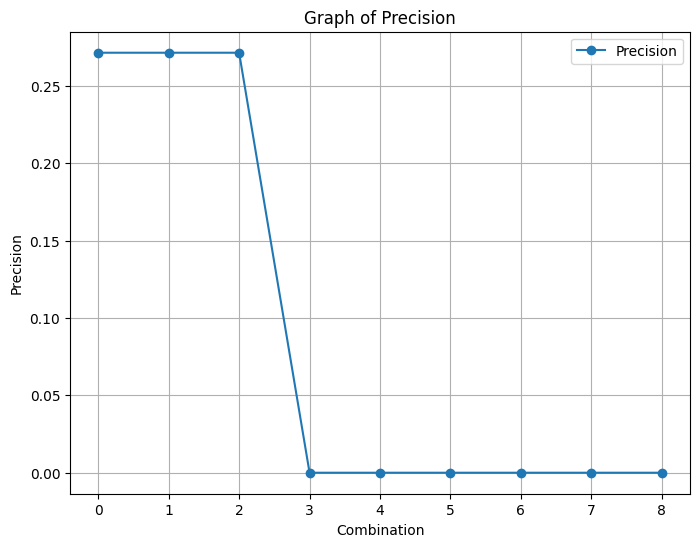

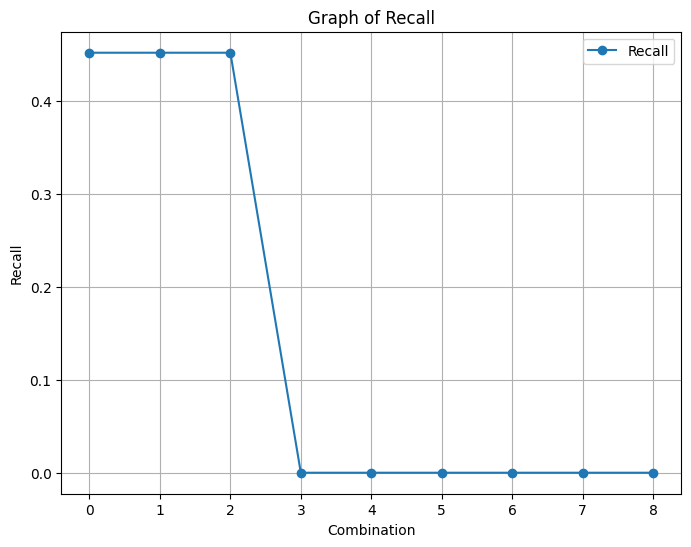

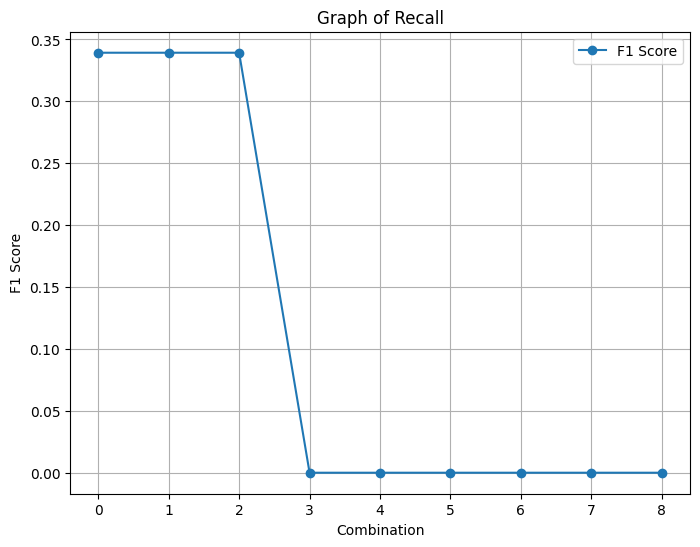

In [ ]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


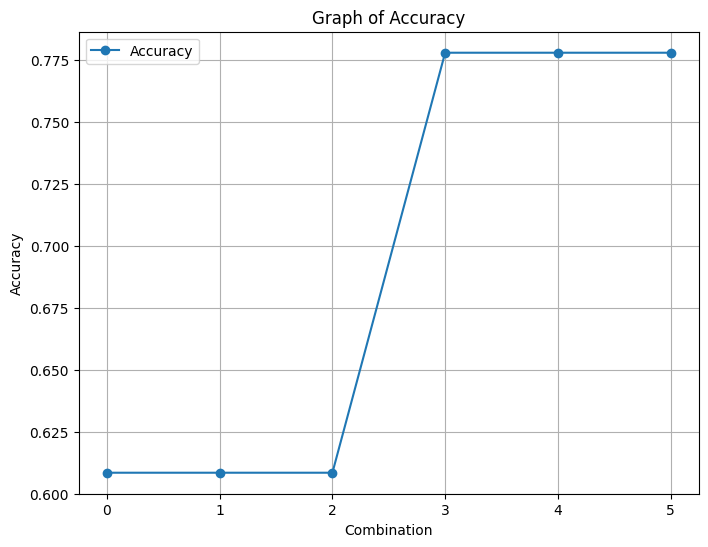

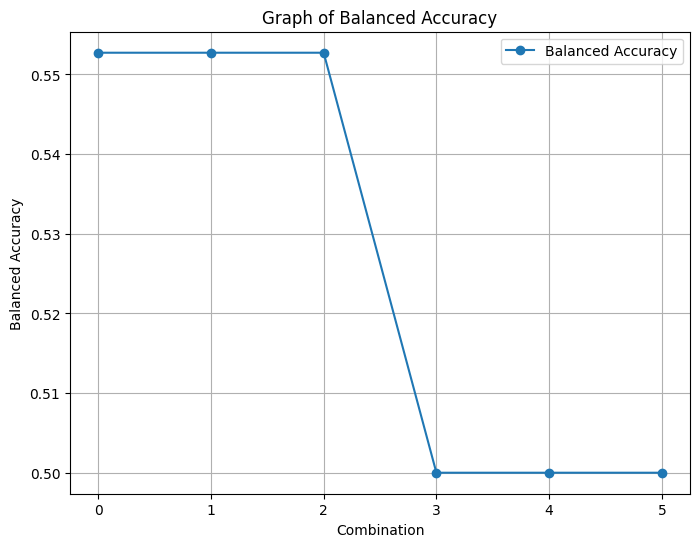

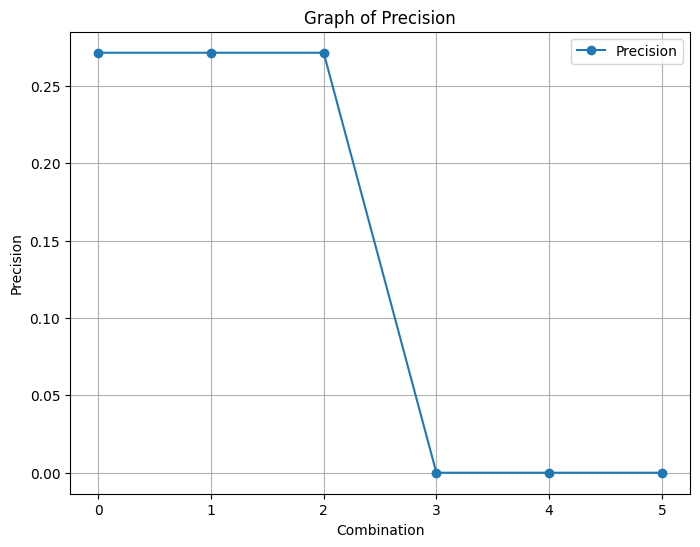

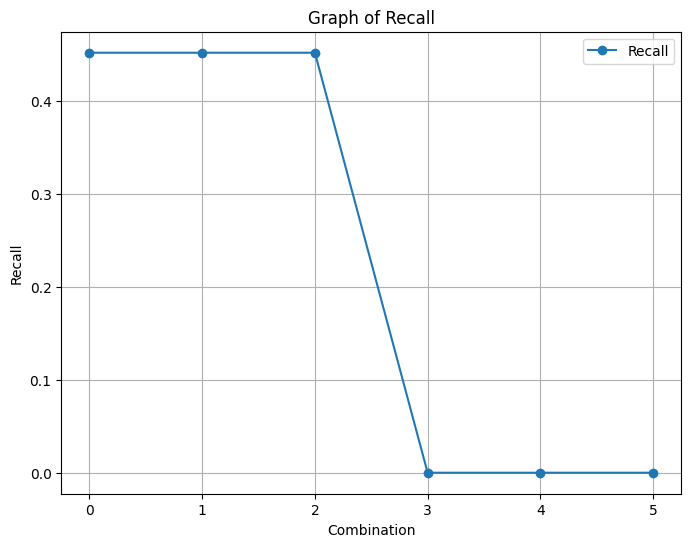

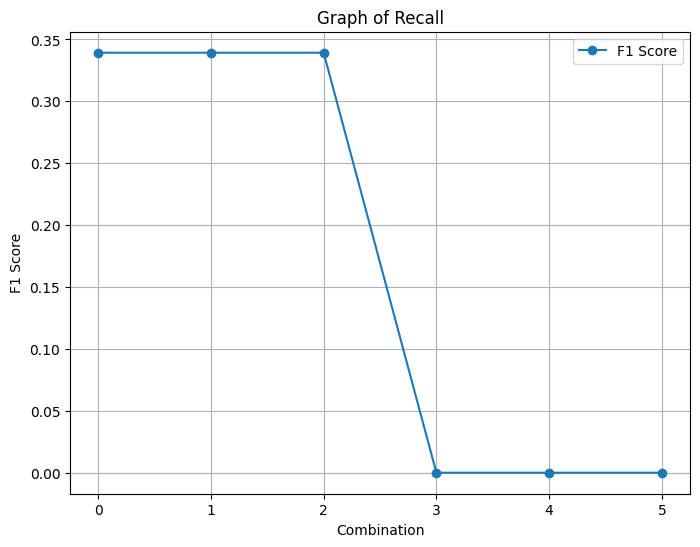

In [ ]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


#extra code

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
predicted_labels = adjective_embeddings
true_labels = Y_train
# Calculating metrics
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')
balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Printing results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Accuracy: {accuracy}")

#Male Graph

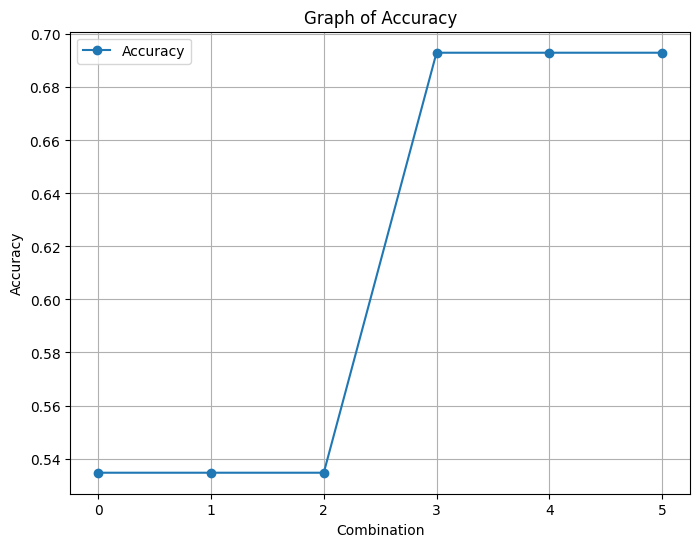

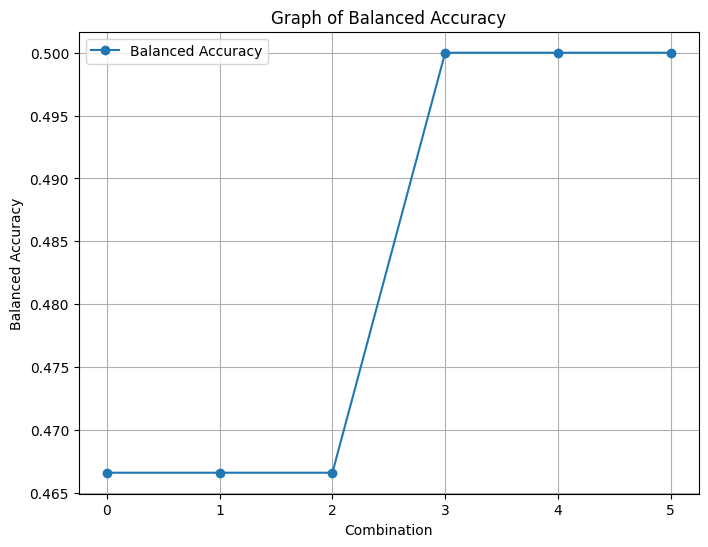

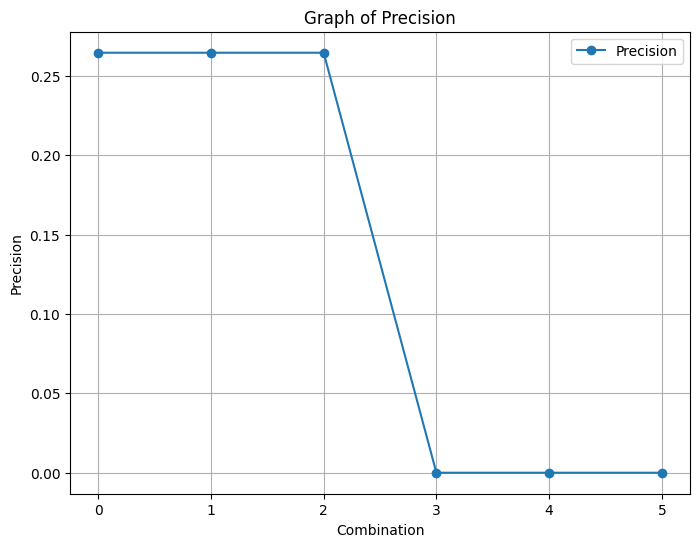

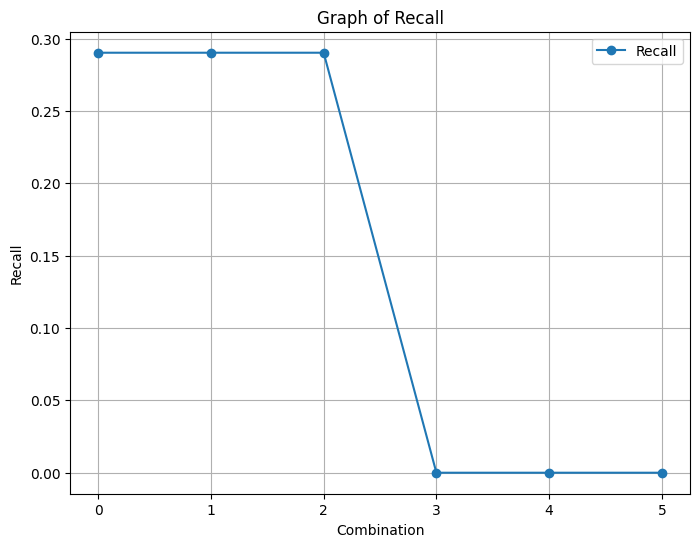

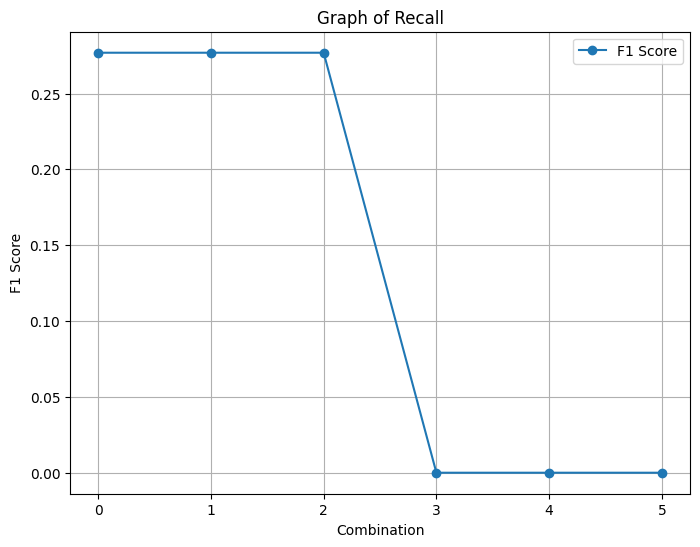

In [ ]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


#Female Graph

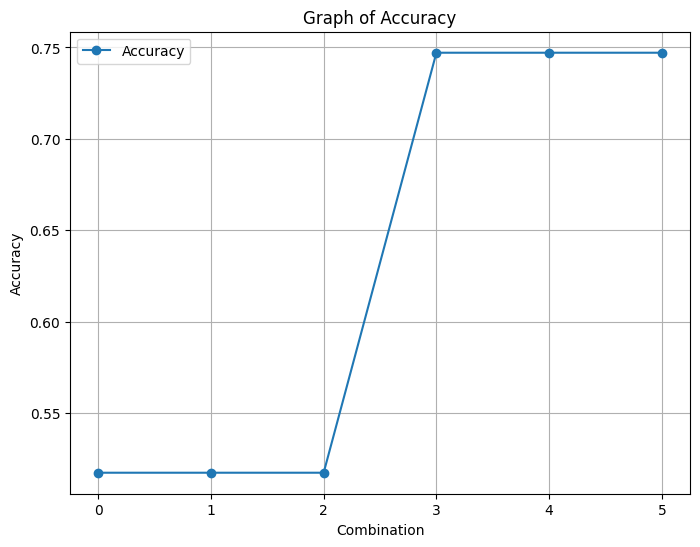

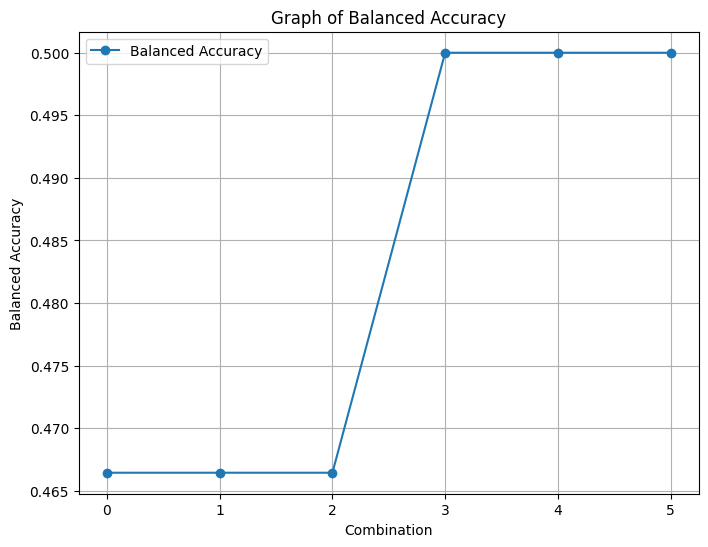

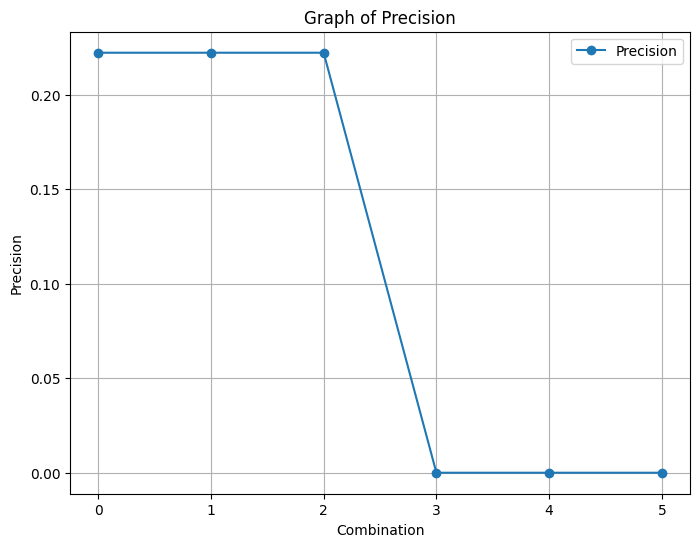

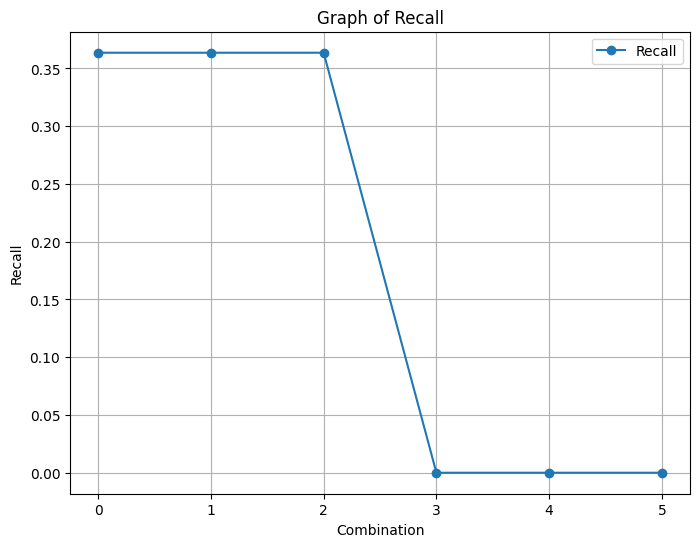

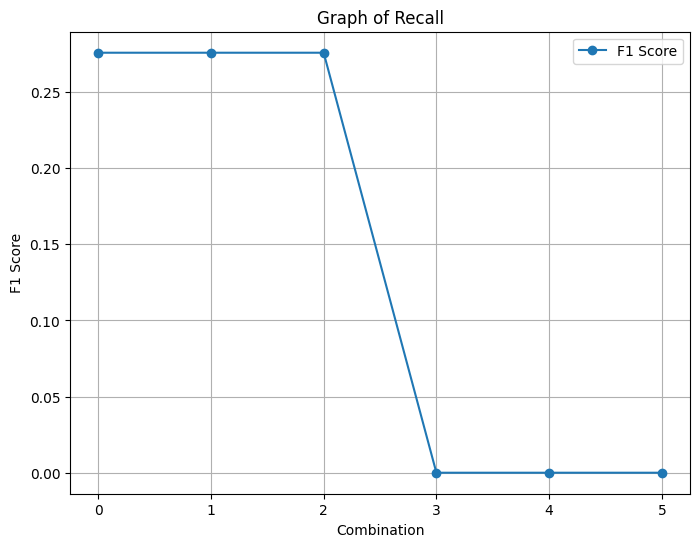

In [ ]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()
